# Lecture 2: Bootstrapping and its Relationship to the Sampling Distribution

## Today's Learning Goals

By the end of this lecture, you should be able to:

1.	Explain why we do not know/have a sampling distribution in practice/real life.
2.	Define bootstrapping.
3.	Write a computer script to create a bootstrap distribution to approximate a sampling distribution.
4.	Contrast a bootstrap sampling distribution with a sampling distribution obtained using multiple samples.

## 1. Why all this emphasis on sampling distributions?

We only have one sample in practice, so we cannot reveal the sampling distribution as we are doing here.

<center>
    <img src="https://media.giphy.com/media/1BmWIWMqfNS7OxnI7D/giphy.gif" width="380" height="350"/>
    <div style="text-align: center"><i>Image from <a href="https://media.giphy.com/media/1BmWIWMqfNS7OxnI7D/giphy.gif">giphy.com</i></a></div>
    <br>
</center>

### 1.1. Why does this happen?

- Sampling is usually costly in terms of human, monetary, and time resources.
- There might be some **ethical implications** in a given inferential/causal study.
- Since our **sample statistic** is also a random variable, it will have some variability associated when estimating a population parameter.
- Just reporting the estimate as a standalone value is not enough.

### 1.2. What have we been doing?

We can approximate the **sampling distribution** of different **estimators** (e.g., the sample mean, median, a given quantile, etc.). In the best-case scenario, if the sample statistic is an **unbiased estimator** of the population parameter, then this parameter's true value will lie in the plausible range provided by the sampling distribution. So far, from a population, we have obtained multiple samples of different sizes to get the corresponding sampling distributions.

```{important}
Nevertheless, what if we only have a single sample?
```

## 2. Population, Sample, and Sampling Distributions

Even though the concepts sound similar, the **sample distribution** and the **sampling distribution of the sample estimate** are not the same. They also do not relate to the population in the same manner. 

### 2.1. The Airbnb Dataset

Let us use the `listings` data. Suppose we wanted to infer something about a population parameter of a **continuous variable**. For instance, a traveller visiting Vancouver may wish to know about the prices of staying somewhere using Airbnb. Particularly, they might be interested in estimating the population mean `price` per night of Airbnb listings in the city. Hence, we are interested in estimating the population parameter $\mu_{\text{price}}$. We will denote our estimate as $\hat{\mu}_{\text{price}}$.

```{attention}
Let us imagine (for learning purposes) that our data set represents the population of **ALL Airbnb** rental `listings` in Vancouver.

Moreover, assume the traveller does not have access to this dataset to compute the population mean $\mu_{\text{price}}$. Therefore, it will be necessary to perform a parameter estimation via sampling **since a census would be unfeasible**.
```

### 2.2. Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
library(cowplot)
library(infer)
library(repr)
library(scales)
library(tidyverse)
options(repr.matrix.max.rows = 6)

── Attaching packages ───────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



### 2.3. Loading the Population Data Set

Recall the data set `listings` contains an `id` number, neighbourhood, type of room, the number of people the rental accommodates, number of bathrooms, bedrooms, beds, and the `price` per night. We will only select the columns corresponding to `id` and `price`.

In [2]:
listings <- read_csv("data/listings.csv")

Rows: 4938 Columns: 74
── Column specification ──────────────────────────────────────────────────────────
Delimiter: ","
chr  (24): listing_url, name, description, neighborhood_overview, picture_ur...
dbl  (37): id, scrape_id, host_id, host_listings_count, host_total_listings_...
lgl   (8): host_is_superhost, host_has_profile_pic, host_identity_verified, ...
date  (5): last_scraped, host_since, calendar_last_scraped, first_review, la...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
listings <- listings %>%
  select(id, price) %>%
  mutate(price = as.numeric(gsub('[$,]','', price)))
listings # N = 4,938 (Population Size)

id,price
<dbl>,<dbl>
10080,150
13357,132
13358,85
⋮,⋮
45398550,53.29
45400161,145.00
45401776,135.00


### 2.4. Starting with the Population

Since we have access to the population dataset, we can do the following:

- Calculate the mean `price` of the population $\mu_{\text{price}}$:

In [4]:
pop_mean_price <- listings %>%
  summarize(pop_mean_price = round(mean(price), 2))
pop_mean_price

pop_mean_price
<dbl>
163.01


- Then, we can create a histogram to visualize the population distribution of `price`.

In [5]:
# Getting summary of our variable of interest.
summary(listings$price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   19.0    85.0   120.0   163.0   186.8  9999.0 

In [6]:
# Setting up plot width and height.
options(repr.plot.width = 15, repr.plot.height = 8)

pop_price_dist <- ggplot(listings, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  annotate("text", x = 950, y = 3000, label = expression(mu["price"] ~ "= 163.01"), size = 7, color = "red") +
  ggtitle("Population Distribution of Price per Night") 

The histogram `pop_price_dist` looks highly right-skewed. According `summary()`, we have large outliers.

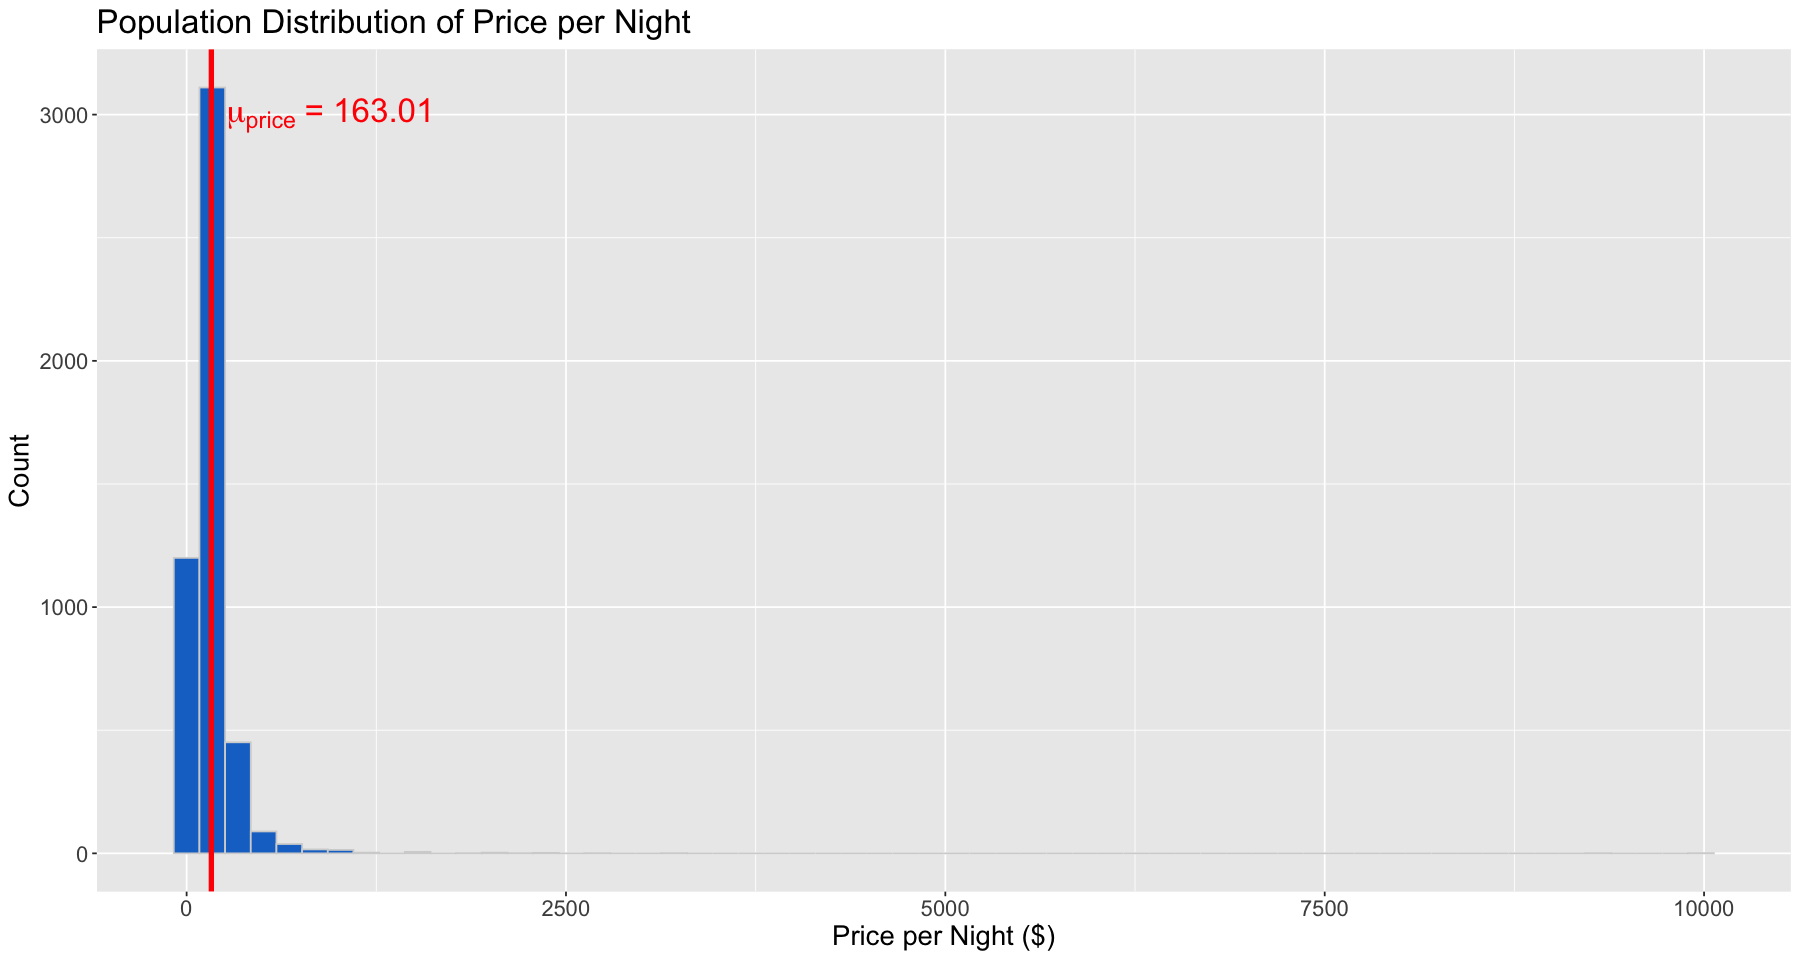

In [7]:
suppressWarnings(print(pop_price_dist))

### 2.5. Sampling and Plotting

Let us collect a sample of size $n = 50$ and visualize its corresponding distribution in terms of `price`. Will it look as similar as `pop_price_dist`?

In [8]:
set.seed(1234) # For reproducibility.
one_sample <- rep_sample_n(listings, size = 50)
one_sample

# Getting summary of our variable of interest.
summary(one_sample$price)

replicate,id,price
<int>,<dbl>,<dbl>
1,15037603,115
1,8556170,99
1,32477935,350
⋮,⋮,⋮
1,17683724,205
1,14580511,99
1,27226611,85


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  28.00   98.25  120.00  156.22  173.50  525.00 

It seems that `one_sample` does not have large outliers as we previously checked in the population. Moreover, how does the sample mean compare to the population mean?

In [9]:
one_sample_mean_price <- one_sample %>%
  summarize(one_sample_mean_price = round(mean(price), 2))
one_sample_mean_price

# Population mean.
pop_mean_price

replicate,one_sample_mean_price
<int>,<dbl>
1,156.22


pop_mean_price
<dbl>
163.01


Even though the population has large outliers, we can see that `one_sample_mean_price` and `pop_mean_price` are quite close. Now, let us plot the histogram for `one_sample` (i.e., the **sample distribution**).

In [10]:
sample_dist_price <- ggplot(one_sample, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 156.22, colour = "purple", size = 1.5) +
  annotate("text", x = 200, y = 7.5, label = expression(mu["price"] ~ "= 163.01"), size = 7, color = "red") +
  annotate("text", x = 120, y = 7.5, label = expression(hat(mu)["price"] ~ "= 156.22"), size = 7, color = "purple") +
  ggtitle("Sample Distribution of Price per Night with n = 50") 

The histogram `sample_dist_price` still looks right-skewed but not as much as `pop_price_dist`.

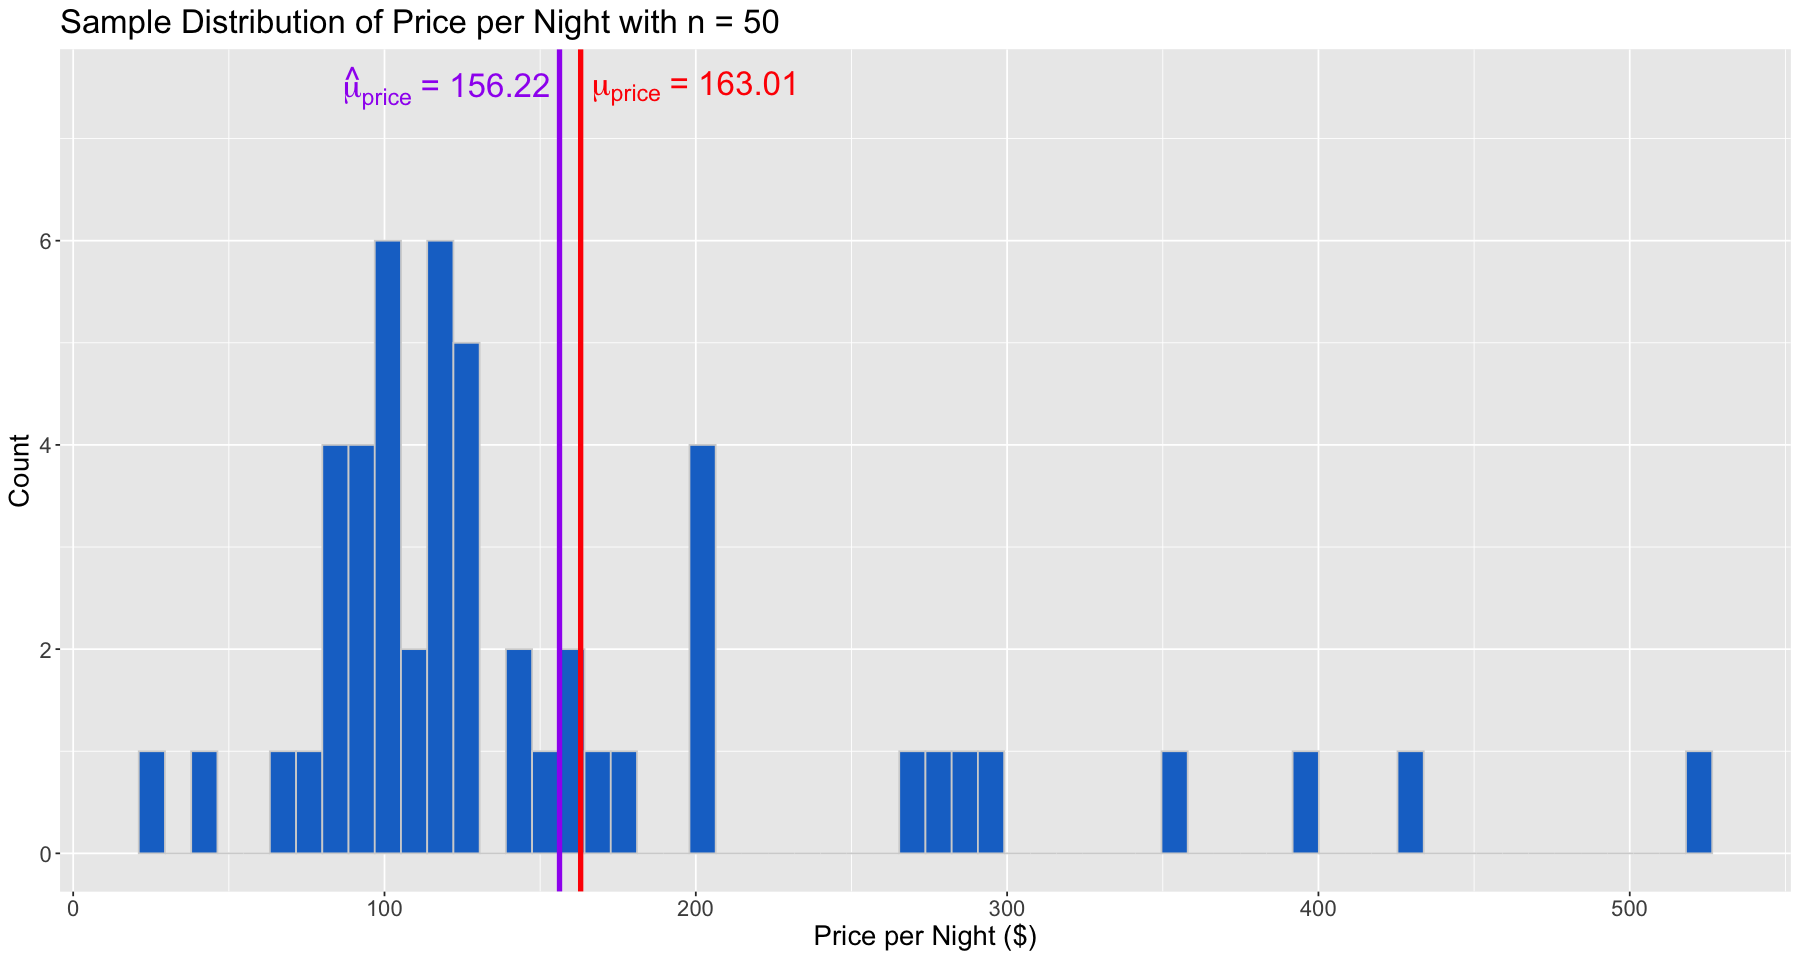

In [11]:
suppressWarnings(print(sample_dist_price))

### 2.6. Multiple Sampling and Plotting

Now, we will draw $m = 1,000$ different random samples of size $n = 50$ from `listings`.

```{caution}
Sample size $n$ and the number of samples $m$ **are not the same thing**.
```

In [12]:
set.seed(1234) # For reproducibility.
multiple_samples_n50 <- rep_sample_n(listings, size = 50, reps = 1000) 
multiple_samples_n50

replicate,id,price
<int>,<dbl>,<dbl>
1,15037603,115
1,8556170,99
1,32477935,350
⋮,⋮,⋮
1000,43652979,55
1000,40266725,69
1000,27763273,40


Let us compute the respective sample means for these $m = 1,000$ samples.

In [13]:
multiple_samples_mean_price_n50 <- multiple_samples_n50 %>%
  summarise(sample_mean = mean(price))
multiple_samples_mean_price_n50

replicate,sample_mean
<int>,<dbl>
1,156.2200
2,145.1800
3,132.8086
⋮,⋮
998,154.9646
999,142.3458
1000,127.4200


Then, we compute the average of the $m = 1,000$ sample means:

$$\bar{\hat{\mu}}_{\text{price}} = \frac{\sum_{i  = 1}^{m} \hat{\mu}_{\text{price}_i}}{m}.$$

In [14]:
multiple_samples_avg_mean_price_n50 <- multiple_samples_mean_price_n50 %>%
  summarize(avg_mean_price_n50 = round(mean(sample_mean), 2))
multiple_samples_avg_mean_price_n50

avg_mean_price_n50
<dbl>
163.03


We can compare the three means we have just computed.

In [15]:
pop_mean_price # Population mean.
one_sample_mean_price # One sample mean of n = 50.
multiple_samples_avg_mean_price_n50 # Average of 1,000 sample means with n = 50.

pop_mean_price
<dbl>
163.01


replicate,one_sample_mean_price
<int>,<dbl>
1,156.22


avg_mean_price_n50
<dbl>
163.03


Note that `pop_mean_price` and `multiple_samples_avg_mean_price_n50` are practically equal. We will now plot the **sampling distribution** of these $m = 1,000$ sample means.

In [16]:
sampling_dist_price_n50 <- ggplot(multiple_samples_mean_price_n50, aes(sample_mean)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 163.03, colour = "limegreen", size = 1.5) +
  annotate("text", x = 210, y = 110, label = expression(mu["price"] ~ "= 163.01"), size = 7, color = "red") +
  annotate("text", x = 115, y = 110, label = expression(bar(hat(mu))["price"] ~ "= 163.03"), size = 7, color = "limegreen") +
  ggtitle("Sampling Distribution of 1,000 Sample Means with n = 50") +
  coord_cartesian(xlim = c(0, 650))

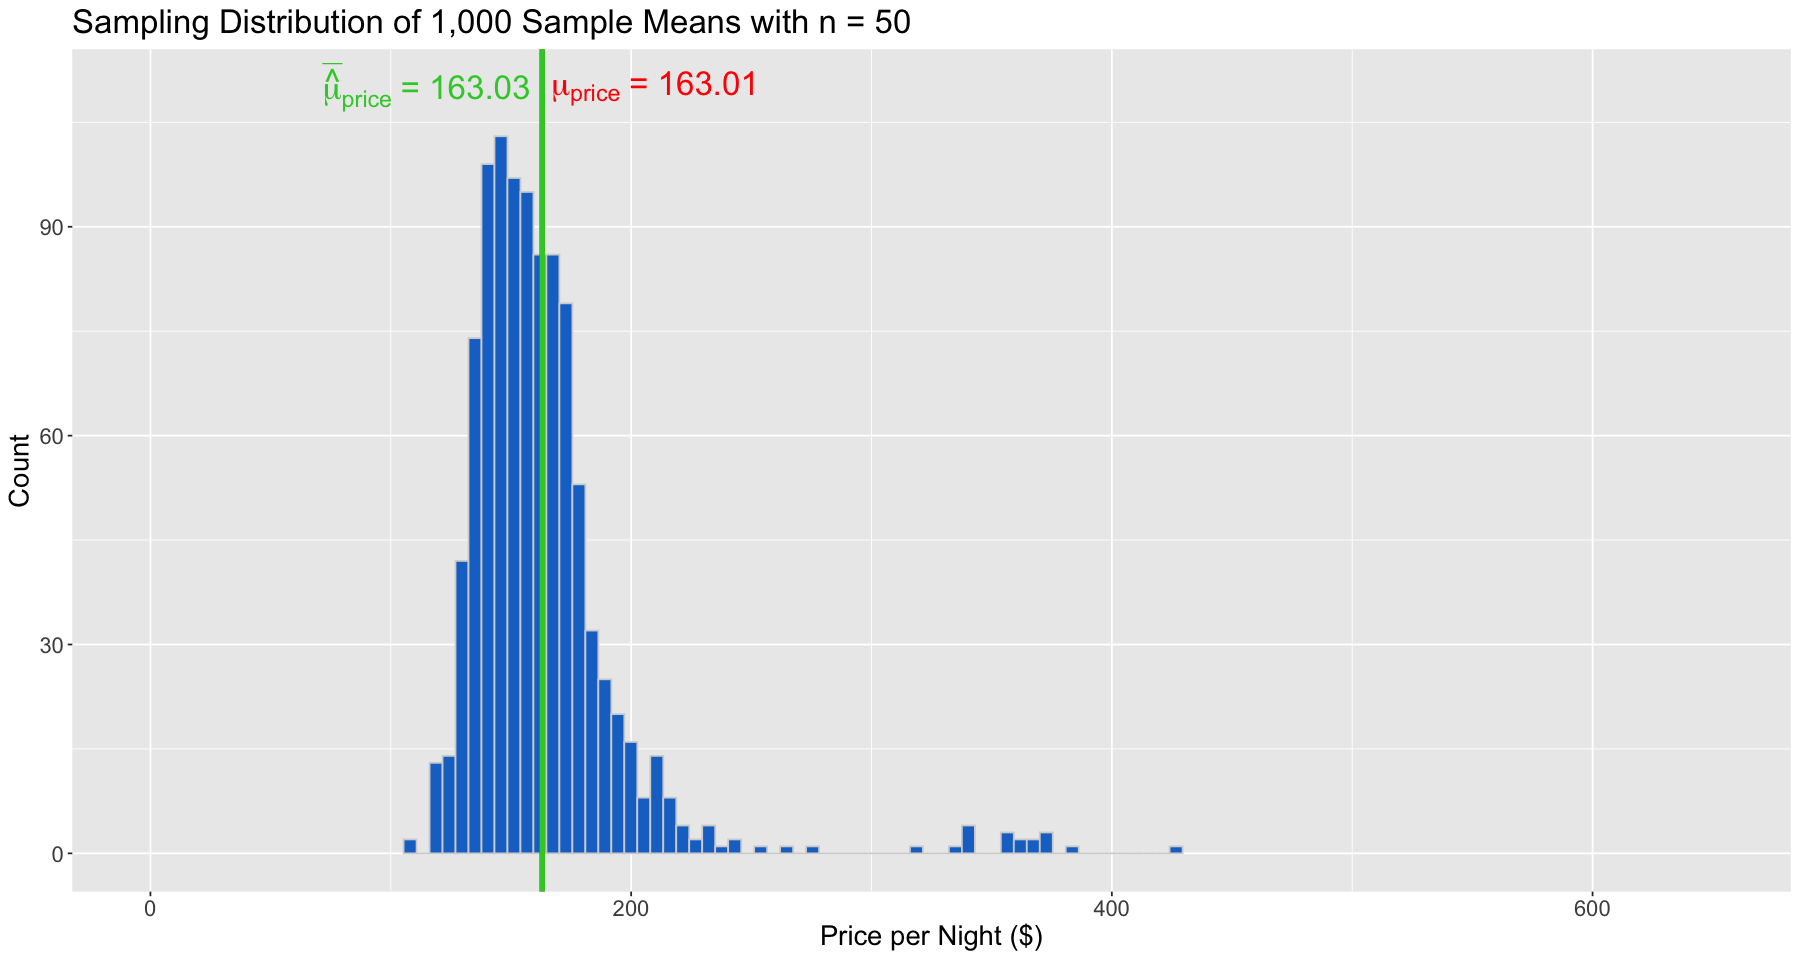

In [17]:
suppressWarnings(print(sampling_dist_price_n50))

### 2.7. Comparing Population, Sample and Sampling Distributions

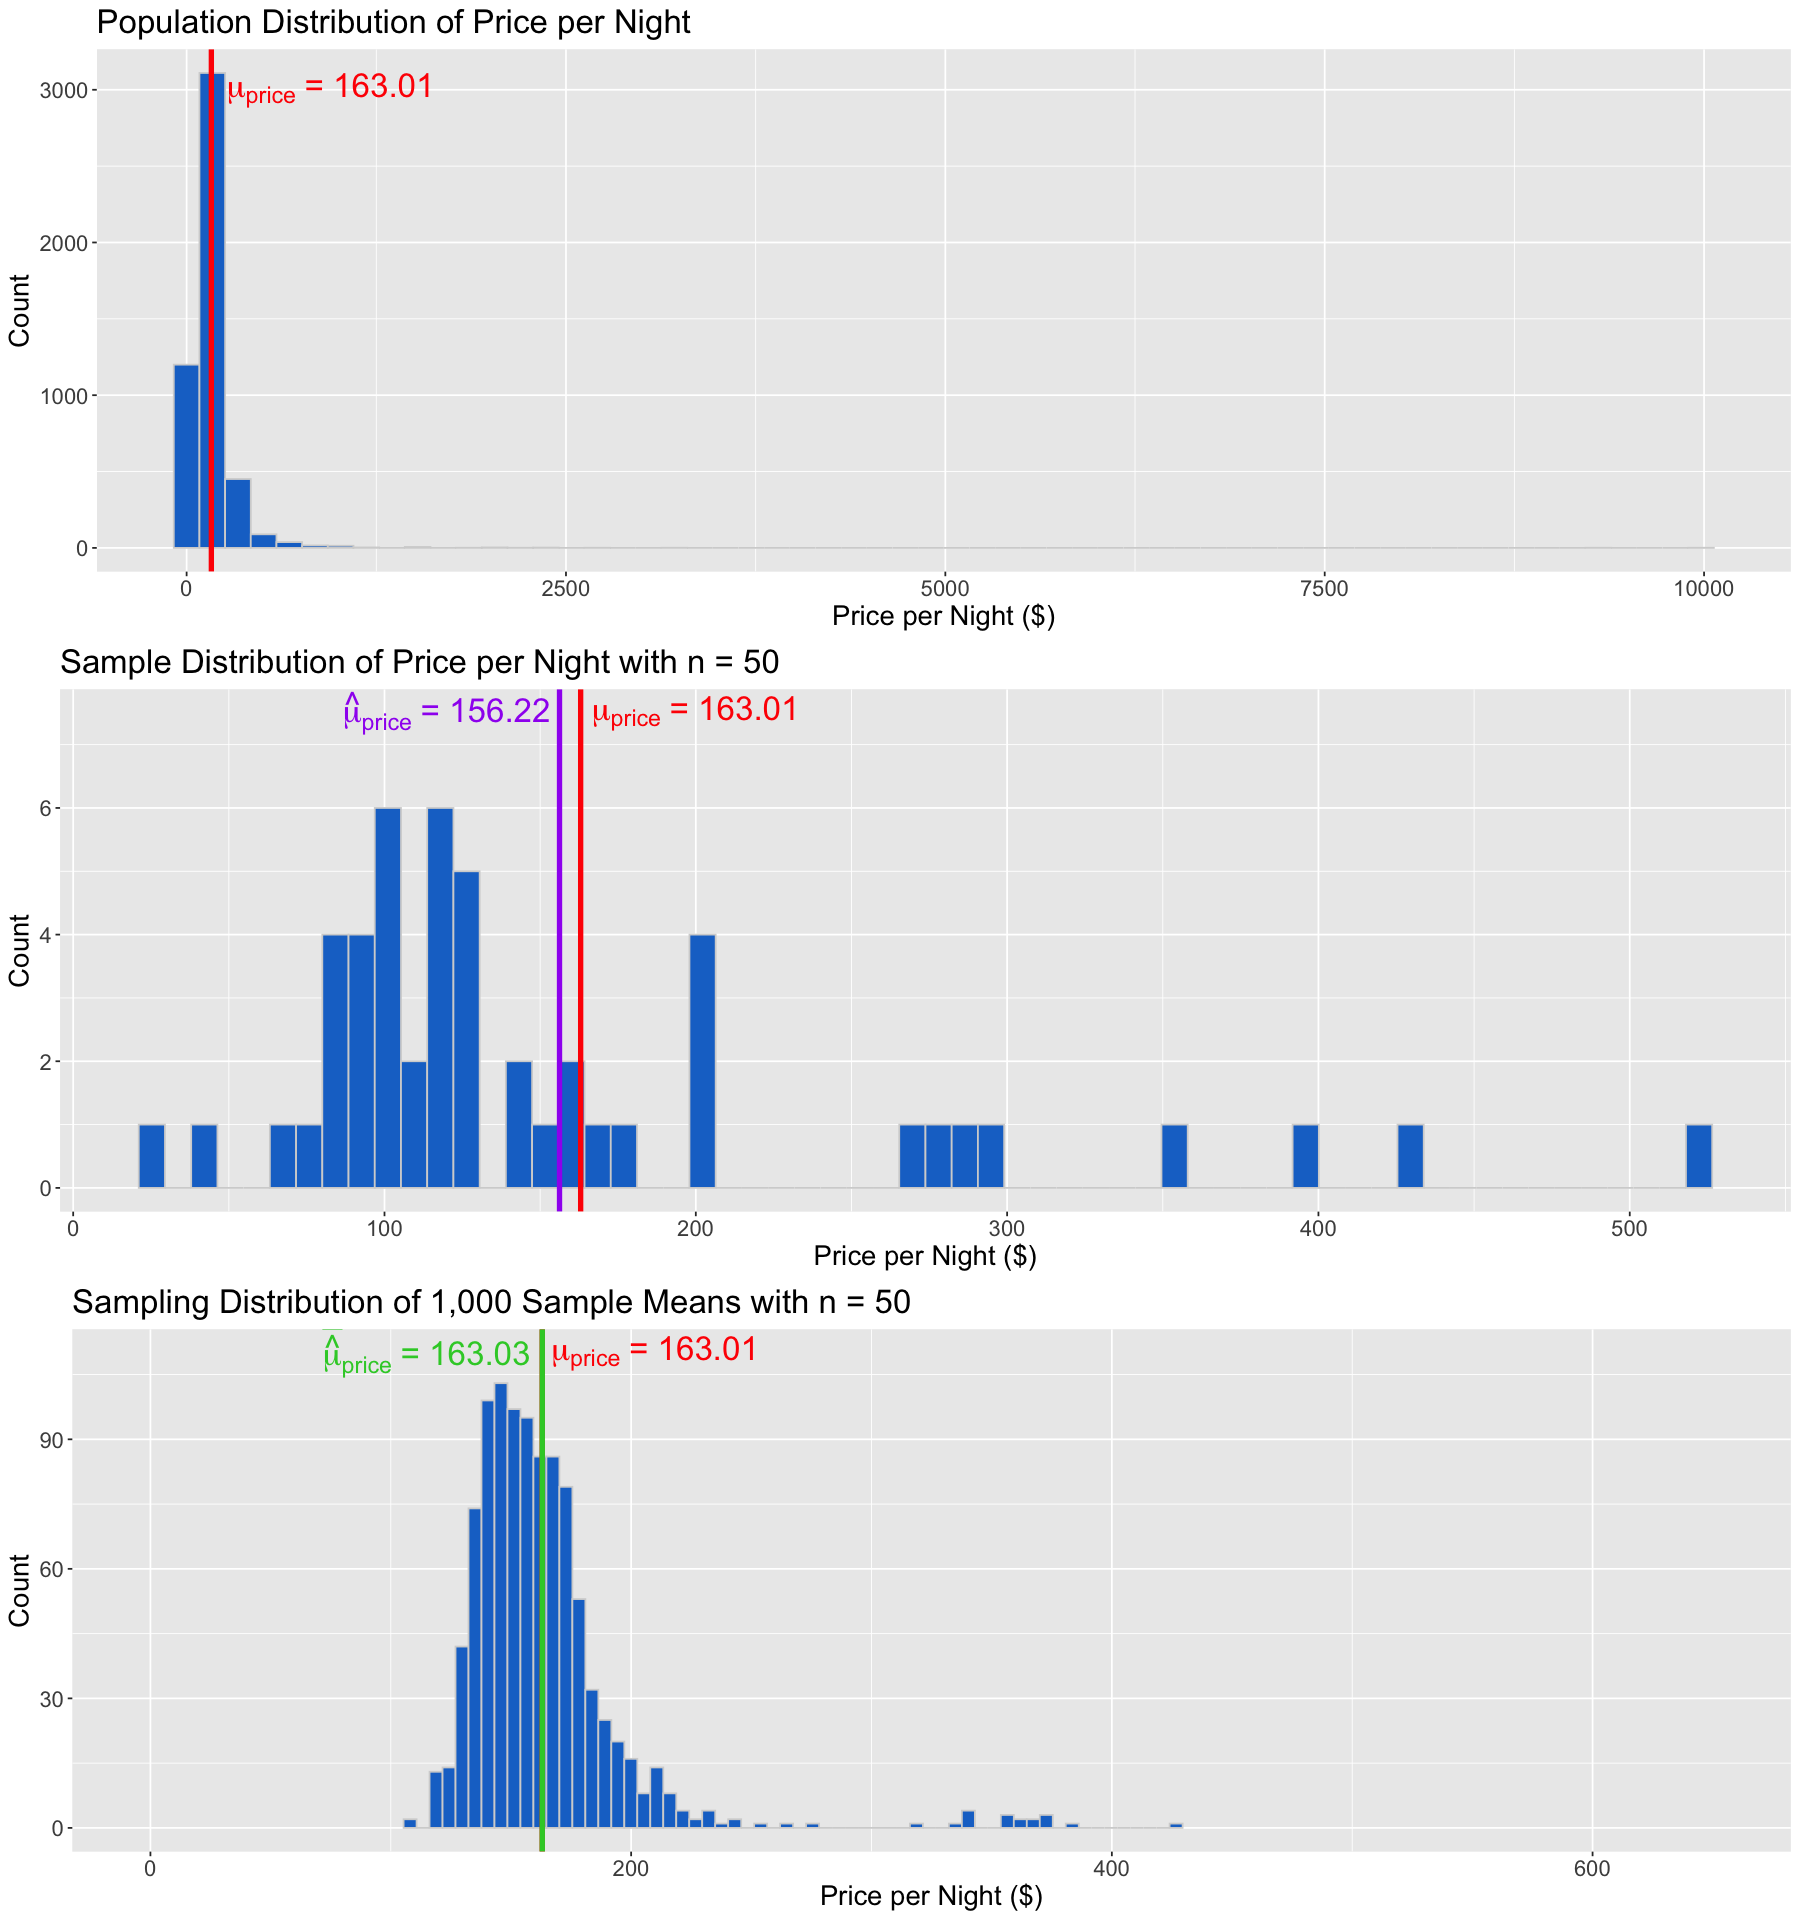

In [18]:
options(repr.plot.width = 15, repr.plot.height = 16)

suppressWarnings(print(plot_grid(pop_price_dist, sample_dist_price, sampling_dist_price_n50, nrow = 3)))

**What do we notice from these plots?**

We can see the following:

- The distribution of `one_sample` looks somewhat like the distribution of the population. Thus, it might even more representative if there were more observations in our sample.
- The sample mean $\hat{\mu}_{\text{price}}$ (our point estimate) from `one_sample` is not exactly the same value of the population parameter $\mu_{\text{price}}$ that we are trying to estimate (but it is close!).
- The shape of the sampling distribution from `multiple_samples_n50` is different from the shape of the population distribution and the sample distribution (in fact, **it is roughly a bell shape!**). 

```{attention} text
Note, there is still some right skewness.
```

- The sampling distribution centre is practically the same value as the population parameter we are trying to estimate.

### 2.8. Sampling Distributions and their Relationship to Sample Size $n$

So far, we have only explored sampling distributions of estimates where our sample size is $n = 50$. Nonetheless, what happens to the sampling distributions of estimates as we change sample size $n$ (particularly with their spreads)?

**What does our sampling distribution of sample means look like when $n = 50$?**

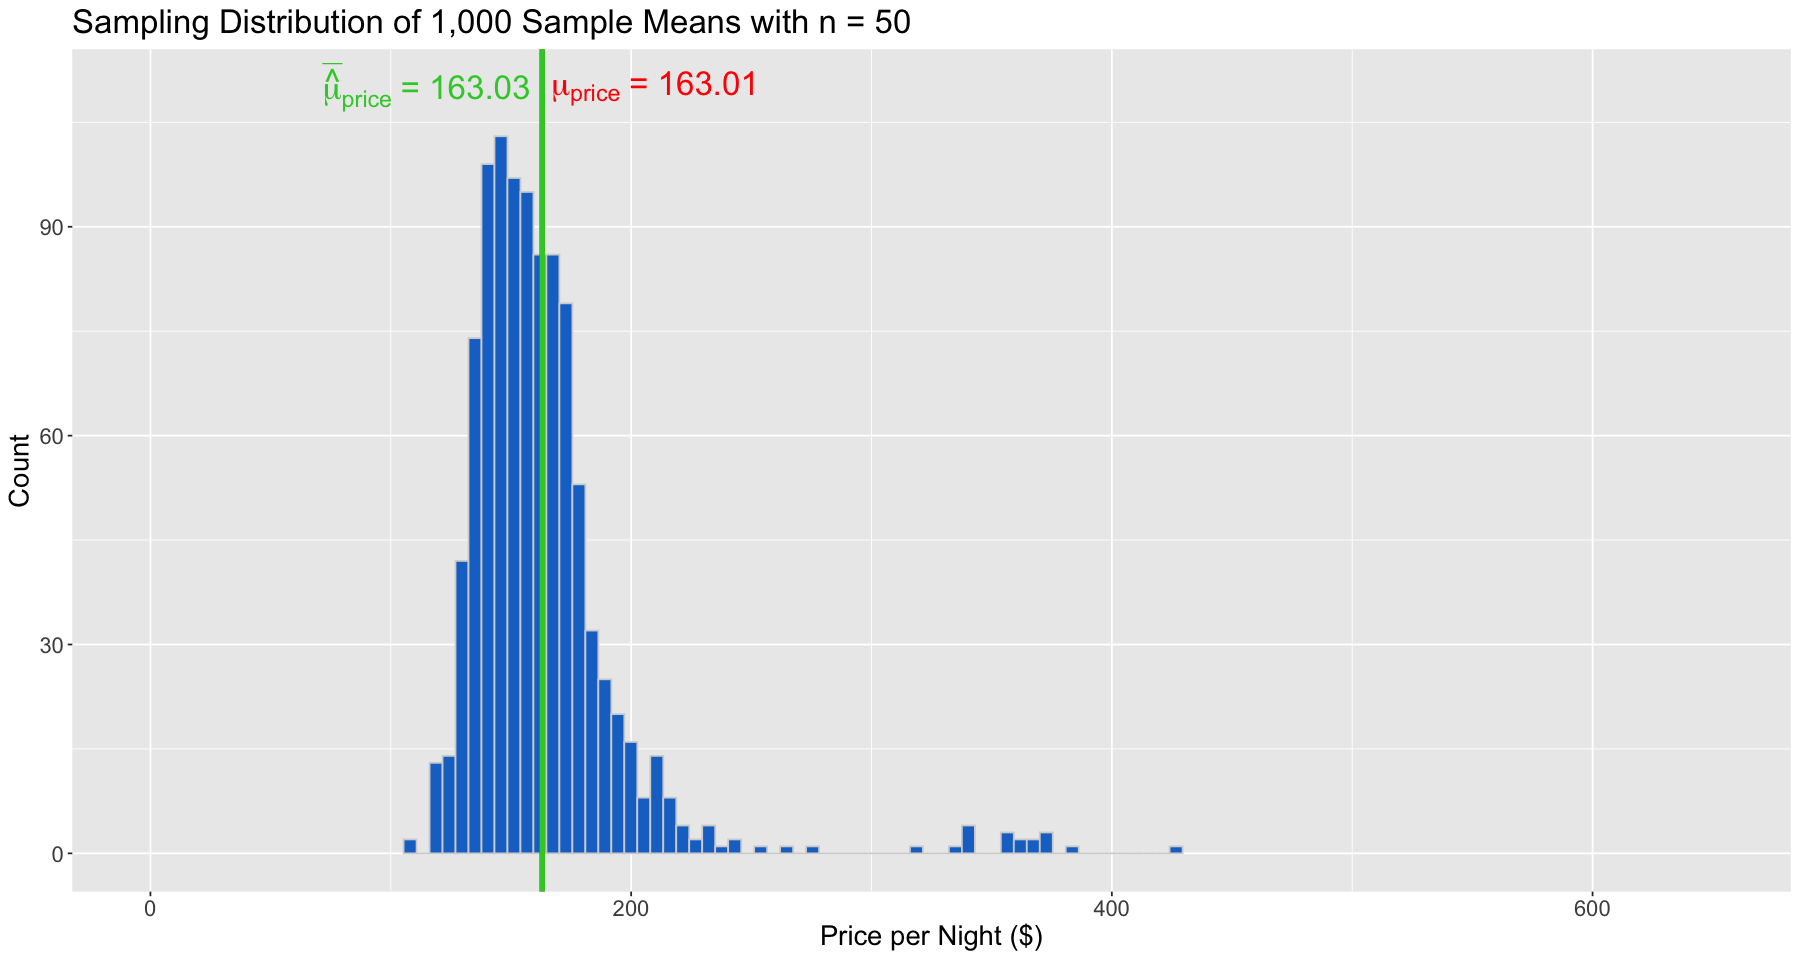

In [19]:
options(repr.plot.width = 15, repr.plot.height = 8)

suppressWarnings(print(sampling_dist_price_n50))

**What happens to our sampling distribution of sample estimates if we set $n = 15$ and $300$ besides $50$?**

Let's do the following tasks:

- Create two additional sampling distributions, one where $n = 15$ and another where $n = 300$.
- Plot these sampling distributions for $m = 1,000$ samples.
- Compute the corresponding standard errors for $n = 15, 50, 300$.

We generate another two sets of $m = 1,000$ each, `multiple_samples_n15` and `multiple_samples_n300`. Then we compute the $m = 1,000$ samples means by set, `multiple_samples_mean_price_n15` and `multiple_samples_mean_price_n300`.

In [20]:
set.seed(1234) # For reproducibility.

multiple_samples_n15 <- rep_sample_n(listings, size = 15, reps = 1000) 
multiple_samples_n300 <- rep_sample_n(listings, size = 300, reps = 1000) 

multiple_samples_mean_price_n15 <- multiple_samples_n15 %>% 
    summarise(sample_mean = mean(price))
multiple_samples_mean_price_n300 <- multiple_samples_n300 %>% 
    summarise(sample_mean = mean(price))

Then, we compute the average of the $m = 1,000$ sample means:

$$\bar{\hat{\mu}}_{\text{price}} = \frac{\sum_{i  = 1}^{m} \hat{\mu}_{\text{price}_i}}{m}.$$

In [21]:
multiple_samples_avg_mean_price_n15 <- multiple_samples_mean_price_n15 %>%
  summarize(avg_mean_price_n15 = round(mean(sample_mean), 2))
multiple_samples_avg_mean_price_n300 <- multiple_samples_mean_price_n300 %>%
  summarize(avg_mean_price_n300 = round(mean(sample_mean), 2))

Let us compare these three averages versus the population mean. All values are pretty similar. **At the end of the day, theoretically, the expected values are equal to the true population parameter.**

In [22]:
pop_mean_price # Population mean.
multiple_samples_avg_mean_price_n15 # Average of 1,000 sample means with n = 25.
multiple_samples_avg_mean_price_n50 # Average of 1,000 sample means with n = 50.
multiple_samples_avg_mean_price_n300 # Average of 1,000 sample means with n = 300.

pop_mean_price
<dbl>
163.01


avg_mean_price_n15
<dbl>
161.16


avg_mean_price_n50
<dbl>
163.03


avg_mean_price_n300
<dbl>
162.34


We will also plot the sampling distributions when $n = 15, 300$.

In [23]:
sampling_dist_price_n15 <- ggplot(multiple_samples_mean_price_n15, aes(sample_mean)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 161.16, colour = "limegreen", size = 1.5) +
  annotate("text", x = 210, y = 195, label = expression(mu["price"] ~ "= 163.01"), size = 7, color = "red") +
  annotate("text", x = 115, y = 195, label = expression(bar(hat(mu))["price"] ~ "= 161.16"), size = 7, color = "limegreen") +
  ggtitle("Sampling Distribution of 1,000 Sample Means with n = 15") +
  coord_cartesian(xlim = c(0, 650))

In [24]:
sampling_dist_price_n300 <- ggplot(multiple_samples_mean_price_n300, aes(sample_mean)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 161.16, colour = "limegreen", size = 1.5) +
  annotate("text", x = 210, y = 110, label = expression(mu["price"] ~ "= 163.01"), size = 7, color = "red") +
  annotate("text", x = 115, y = 110, label = expression(bar(hat(mu))["price"] ~ "= 162.34"), size = 7, color = "limegreen") +
  ggtitle("Sampling Distribution of 1,000 Sample Means with n = 300") +
  coord_cartesian(xlim = c(0, 650))

Finally, we will compare the three sampling distributions. Note that the $x$-axes are adjusted on the same scale.

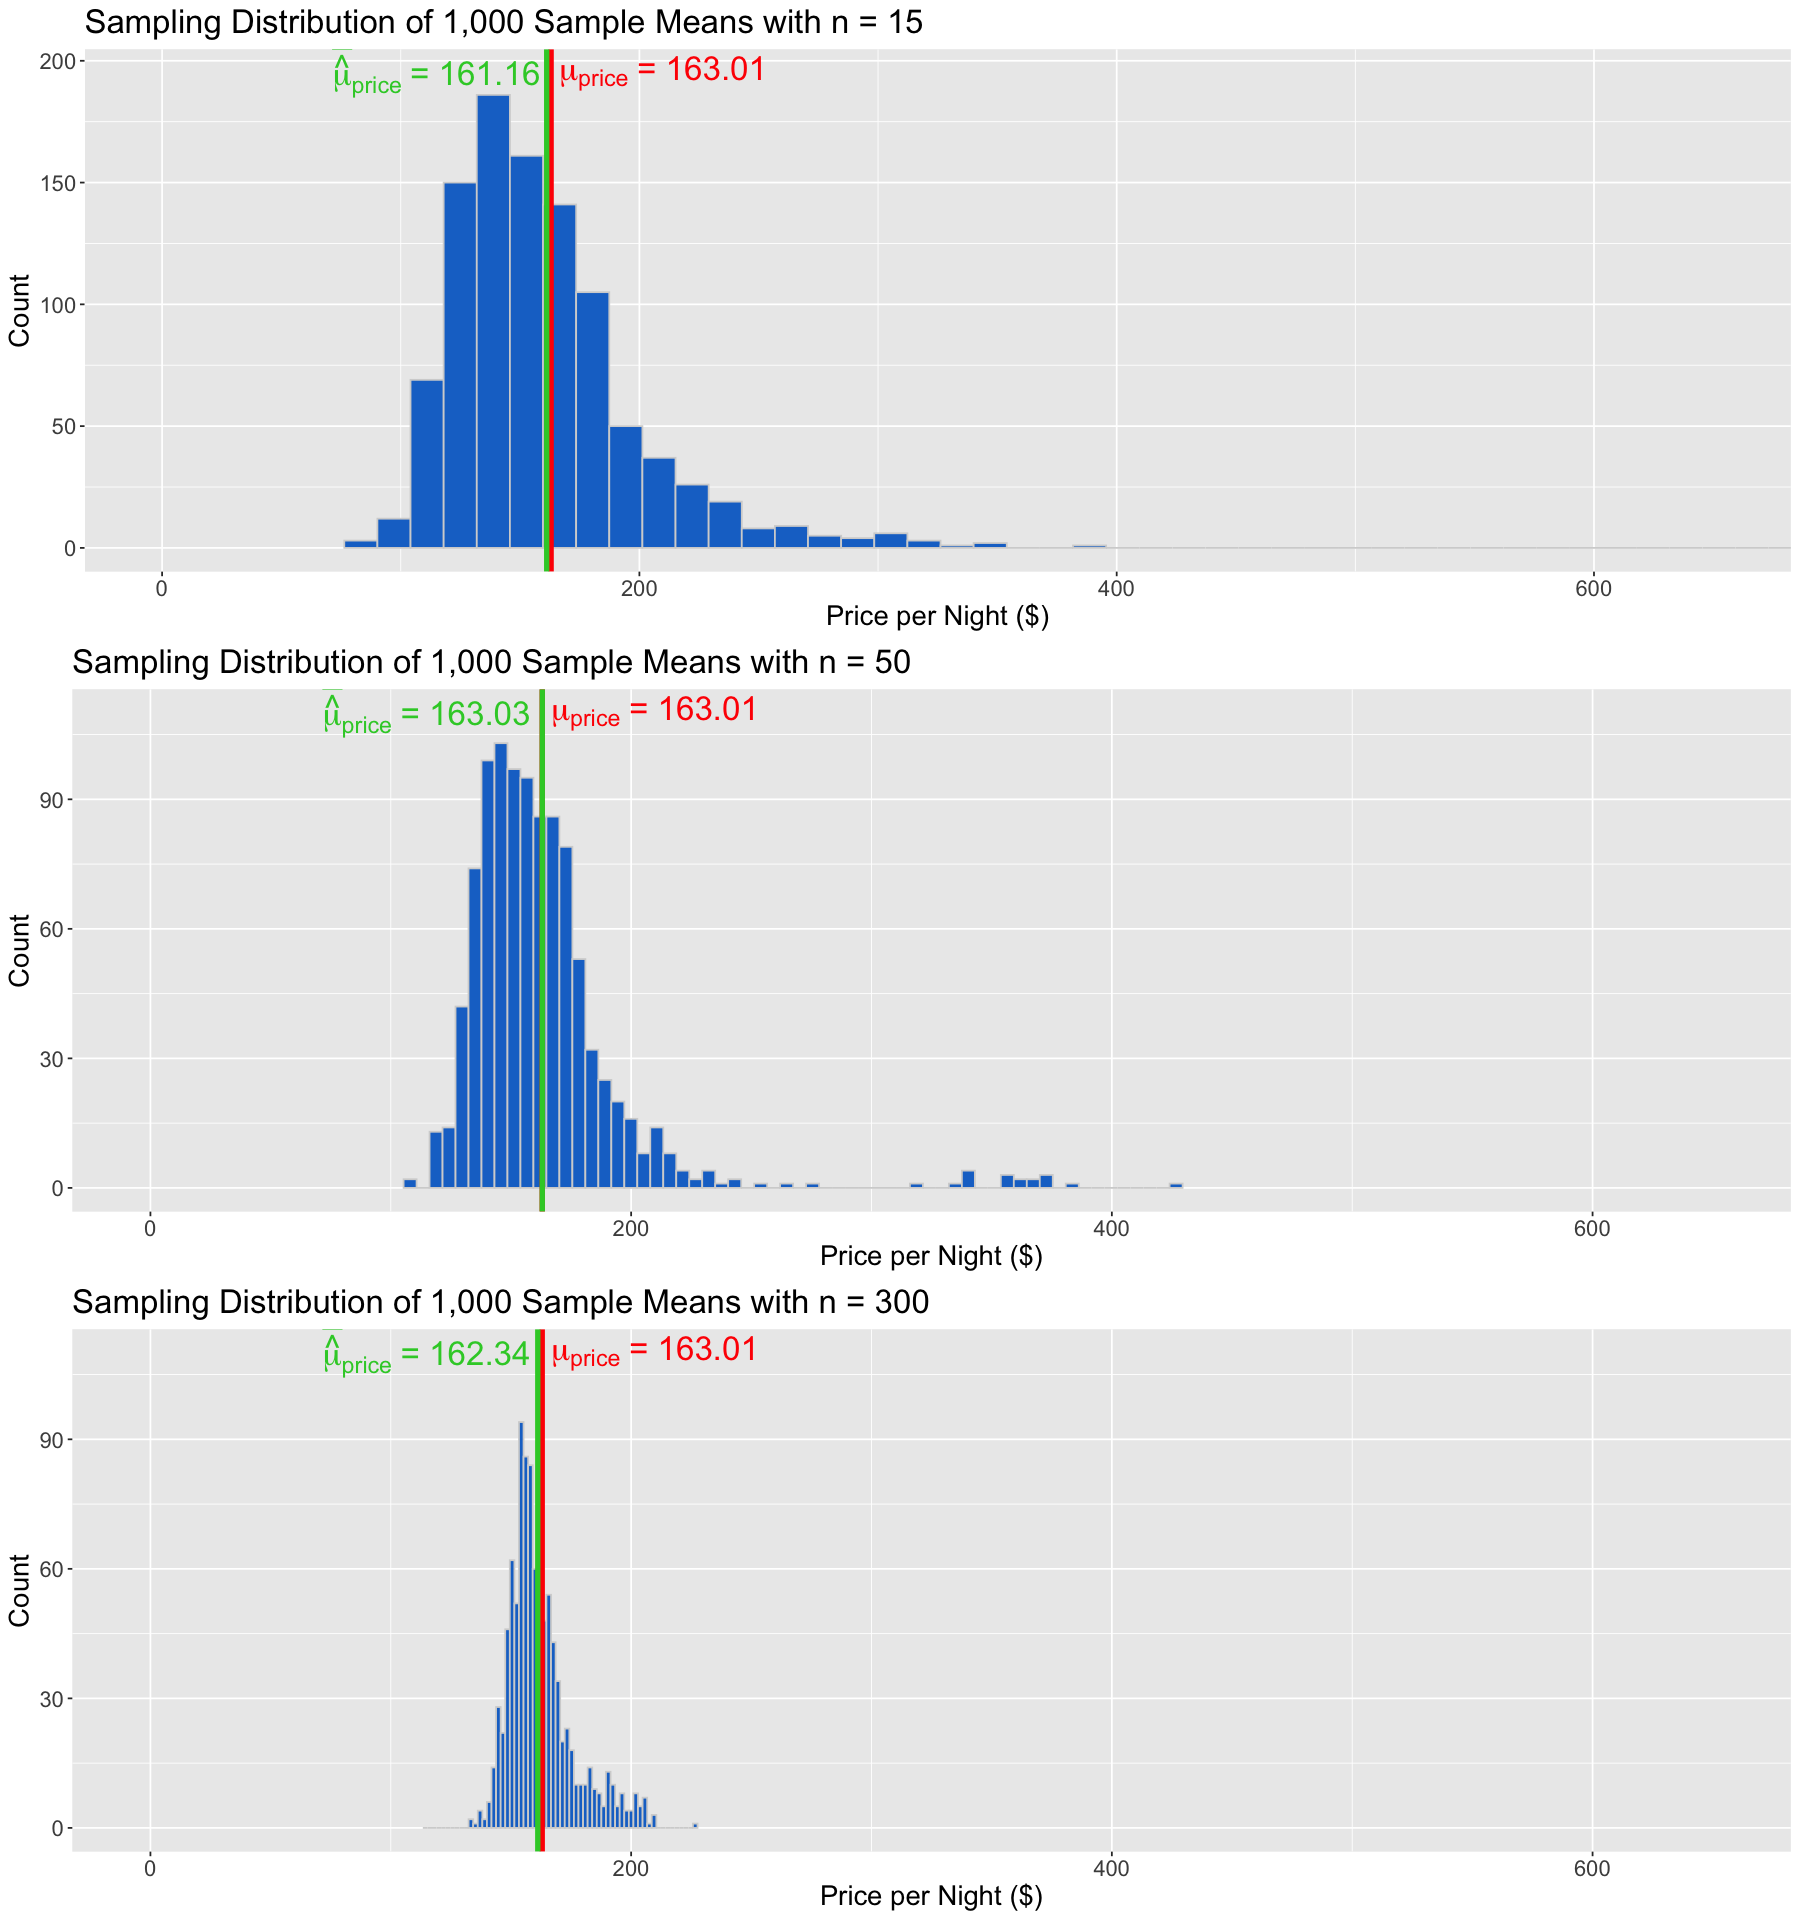

In [25]:
options(repr.plot.width = 15, repr.plot.height = 16)

suppressWarnings(print(plot_grid(sampling_dist_price_n15, sampling_dist_price_n50, sampling_dist_price_n300, nrow = 3)))

**What do we notice in these three histograms?**

We can list the following:

- As we increase the sample size $n$, our sampling distribution gets narrower.
- As we increase the sample size $n$, the **standard error** gets smaller.
- As we increase our sample size $n$, each sample is more likely to have an estimate closer to the true population parameter we are trying to estimate (compared to samples with a smaller number of observations).

**Can we quantify this closeness?**

We can do this through the standard error, which is **the standard deviation of the sampling distribution of a sample estimate**. 

```{attention}
The standard deviation is a measure of the spread of a distribution.
```

Let us calculate the standard error for each sample size.

In [26]:
sampling_std_error <- tibble(n = c(15, 50, 300), se = c(
  multiple_samples_mean_price_n15 %>%
    pull(sample_mean) %>%
    sd(),
  multiple_samples_mean_price_n50 %>%
    pull(sample_mean) %>%
    sd(),
  multiple_samples_mean_price_n300 %>%
    pull(sample_mean) %>%
    sd()
))

As the sample size increases, the standard error decreases.

In [27]:
sampling_std_error

n,se
<dbl>,<dbl>
15,50.84547
50,34.72639
300,13.84597


### 2.9. But, we only have one sample!

We have used **multiple-sample** simulation and sampling distributions to learn whether a sample can estimate the population parameter we are interested in inferring. But in reality, most of the time, we only have one sample. Hence, how can we dig into the variability and distribution of our point estimates?

### 2.10. Quantifying the variability/uncertainty around our point estimate

We want to come up with a plausible range of values around our observed point estimate. This range will depend on how precise and accurate our sample point estimate is to the **real and unknown** the population parameter. Quantifying variability/uncertainty requires measuring how much we would expect this point estimate to vary from sample to sample. Essentially, in the one-sample case, **we need to approximate the sampling distribution to create this plausible range**.

### 2.11. Two ways to quantify variability/uncertainty

- **Via computation:** We can use bootstrapping. This approach is pretty flexible since it can be applied to different statistics such as the sample mean, median, a given quantile, etc.
- **Via a theoretical shortcut:** Central Limit Theorem (CLT).

```{important}
CLT is only applicable to sample means.
```

## 3. Boostrapping

The term **bootstrapping** comes from the phrase "*pulling oneself up by one’s bootstraps*," which is a metaphor for accomplishing an impossible task without outside help. In this case, the impossible task is estimating a population parameter and describing how precise and accurate our point estimate is. We will accomplish it using data from only a single sample. 

However, **a representative sample is critical for this approach to succeed**. Thus, we use the sample as a proxy of the population; this is a major bootstrapping feature! We get back to the importance of a proper sampling method we discussed in our previous lecture.

### 3.1. What are the basic bootstrapping steps?

1. Take a bootstrap sample - a random sample **taken with replacement** from the original sample of the same size $n$.
2. Calculate the bootstrap point estimate from that bootstrap sample.
3. Repeat steps *(1)* and *(2)* $b$ times to create a bootstrap distribution - a distribution of bootstrap point estimates.
4. Calculate the plausible range of values around our $b$ observed point estimates (we will call this an *empirical confidence interval*).

### 3.2. Bootstrapping in `R`

Let's retake with our `one_sample` of $n = 50$ that we created earlier as our single sample. Recall it looks like this:

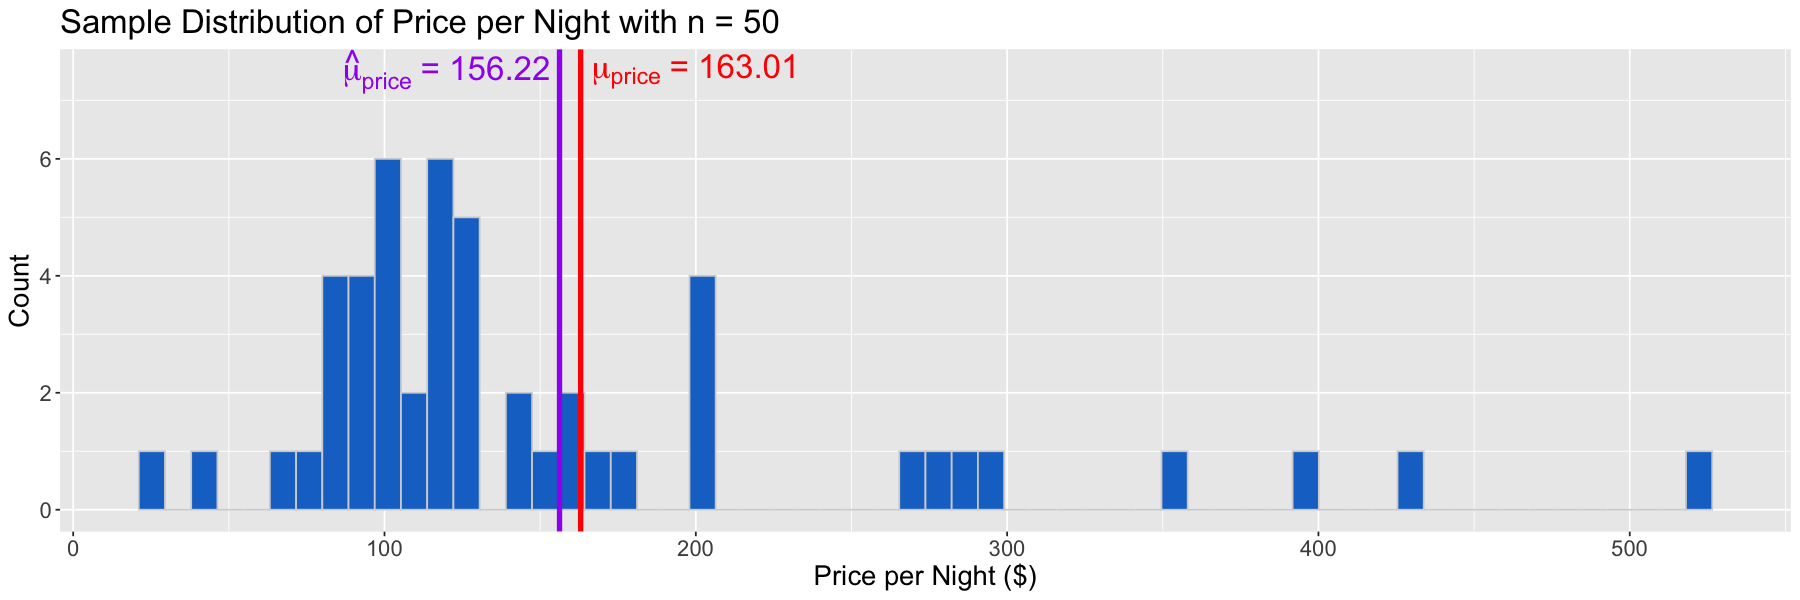

In [28]:
options(repr.plot.width = 15, repr.plot.height = 5)
suppressWarnings(print(sample_dist_price))

```{important}
To make bootstrapping work with the `infer` package functions, we need to drop the first column (named `replicate`) since we will generate this column again if we are bootstrapping. We also need to ungroup this data frame too. This is because, in real life, you would only have one sample.
```

In [29]:
one_sample

replicate,id,price
<int>,<dbl>,<dbl>
1,15037603,115
1,8556170,99
1,32477935,350
⋮,⋮,⋮
1,17683724,205
1,14580511,99
1,27226611,85


In [30]:
# Ungrouping and dropping `replicate` column.
one_sample <- one_sample %>%
  ungroup() %>%
  select(id, price)
one_sample

id,price
<dbl>,<dbl>
15037603,115
8556170,99
32477935,350
⋮,⋮
17683724,205
14580511,99
27226611,85


**Using `rep_sample_n()`**

To generate a single bootstrap sample in `R`, we can use the `rep_sample_n()` as we did when creating our sampling distribution. However, this time we will change the default argument for `replace` from `FALSE` to `TRUE` (i.e., **sampling with replacement**):

In [31]:
set.seed(4567) # For reproducibility.
bootstrap_sample1 <- one_sample %>%
  rep_sample_n(size = 50, replace = TRUE, reps = 1)

### 3.3. Comparing `bootstrap_sample1` to original `one_sample` mean

In [32]:
mean_price_bootstrap_sample1 <- bootstrap_sample1 %>%
  summarize(mean_price_bootstrap_sample1 = round(mean(price), 2))
mean_price_bootstrap_sample1

one_sample_mean_price

replicate,mean_price_bootstrap_sample1
<int>,<dbl>
1,158.4


replicate,one_sample_mean_price
<int>,<dbl>
1,156.22


Now, let us plot the histogram for `bootstrap_sample1`.

In [33]:
bootstrap_sample1_dist_price <- ggplot(bootstrap_sample1, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 156.22, colour = "purple", size = 1.5) +
  geom_vline(xintercept = 158.4, colour = "orange", size = 1.5) +
  annotate("text", x = 210, y = 7.5, label = expression(mu["price"] ~ "= 163.01"), size = 6, color = "red") +
  annotate("text", x = 200, y = 8.5, label = expression(hat(mu)["price"] ~ "= 156.22"), size = 6, color = "purple") +
  annotate("text", x = 197, y = 9.5, label = expression(hat(mu)["price"]^"(B)" ~ "= 158.4"), size = 6, color = "orange") +
  ggtitle("Bootstrap Sample Distribution of Price per Night with n = 50") 

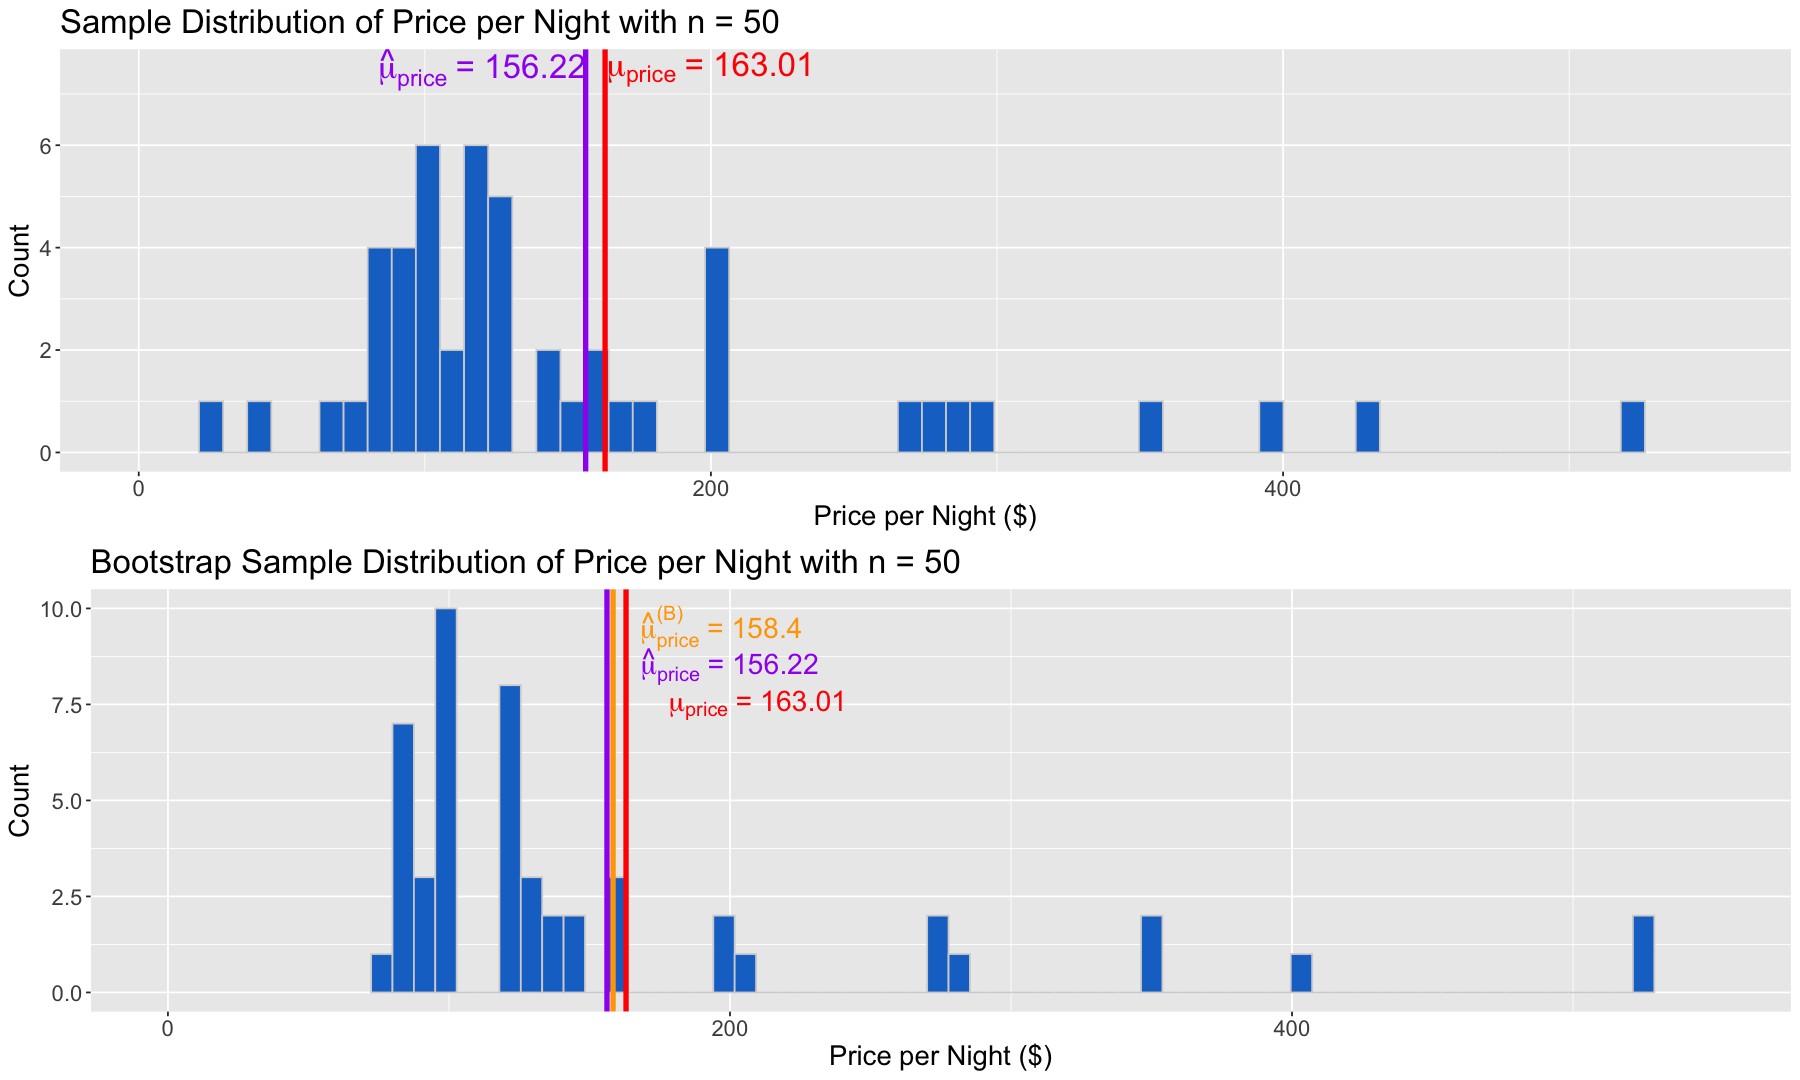

In [34]:
options(repr.plot.width = 15, repr.plot.height = 9)
suppressWarnings(print(plot_grid(sample_dist_price + coord_cartesian(xlim = c(0, 550)), bootstrap_sample1_dist_price + coord_cartesian(xlim = c(0, 550)), nrow = 2)))

These two distributions look different because we sampled **with replacement** from `one_sample` to generate `bootstrap_sample1`. Nevertheless, we still see right-skewness in `bootstrap_sample1`.

**How about 6 bootstrap samples?**

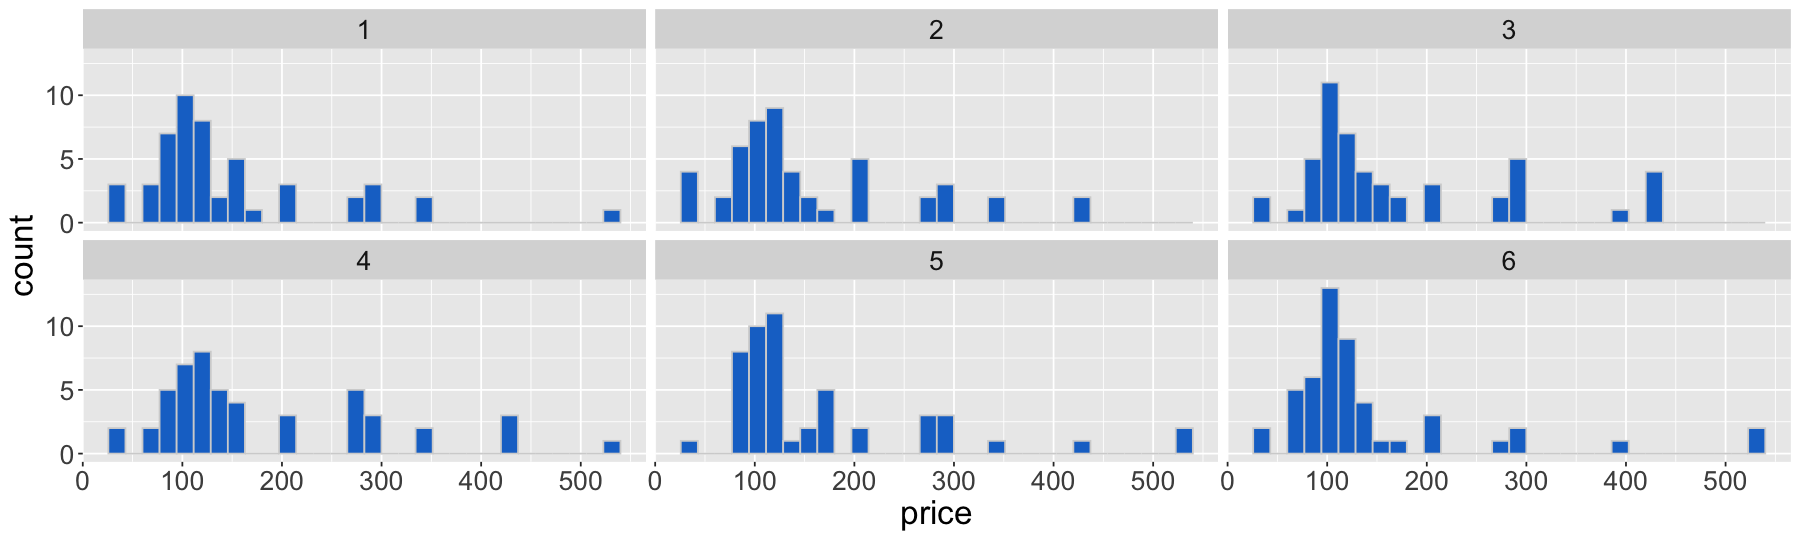

In [35]:
set.seed(1234) # For reproducibility.
six_bootstrap_samples <- one_sample %>%
  rep_sample_n(size = 50, replace = TRUE, reps = 6)

options(repr.plot.width = 15, repr.plot.height = 4.5)
ggplot(six_bootstrap_samples, aes(x = price)) +
  geom_histogram(bins = 30, fill = "dodgerblue3", color = "lightgrey") +
  facet_wrap(~replicate) +
  theme(text = element_text(size = 20))

The right-skewness is still present! What are the means of these 6 bootstrap samples?

In [36]:
six_bootstrap_samples %>% 
  summarize(bootstrap_sample_mean = mean(price))
pop_mean_price

replicate,bootstrap_sample_mean
<int>,<dbl>
1,147.76
2,153.10
3,173.12
4,179.36
5,166.22
6,143.80


pop_mean_price
<dbl>
163.01


The bootstrap sample distributions and point estimates (here means) are different. **This is due to the sampling with replacement**.

**How about $b = 1,000$ bootstrap samples?**

The `infer` package has a nice framework that we can use to simplify this process:

```{figure} https://d33wubrfki0l68.cloudfront.net/1cd0a53125c3b7dc4b12c04780f7f5b204ecbb1e/98111/images/flowcharts/infer/visualize.png
:height: 400px
:name: infer_workflow_boostrapping

Image from [*Ismay and Kim (2021)*](https://moderndive.com/8-confidence-intervals.html#bootstrap-35-replicates).
```

Let us use these functions to generate these $b = 1,000$ bootstrap samples.

In [37]:
set.seed(789) # For reproducibility.
bootstrap_distribution_n50 <- ungroup(one_sample) %>%
  specify(response = price) %>%
  generate(reps = 1000) %>%
  calculate(stat = "mean")
bootstrap_distribution_n50

Setting `type = "bootstrap"` in `generate()`.



replicate,stat
<int>,<dbl>
1,151.48
2,181.10
3,152.02
⋮,⋮
998,146.88
999,154.16
1000,144.20


Then, we compute the average of the $b = 1,000$ sample means

$$\bar{\hat{\mu}}_{\text{price}}^{(B)} = \frac{\sum_{i  = 1}^{b} \hat{\mu}_{\text{price}_i}^{(B)}}{b}$$

In [38]:
bootstrap_samples_avg_mean_price_n50 <- bootstrap_distribution_n50 %>%
  summarize(boot_avg_mean_price_n50 = round(mean(stat), 2))
bootstrap_samples_avg_mean_price_n50

boot_avg_mean_price_n50
<dbl>
156.35


Let us compare these two averages versus the population mean.

In [39]:
pop_mean_price # Population mean.
multiple_samples_avg_mean_price_n50 # Average of 1,000 sample means with n = 50.
bootstrap_samples_avg_mean_price_n50 # Average of 1,000 bootstrap sample means with n = 50.

pop_mean_price
<dbl>
163.01


avg_mean_price_n50
<dbl>
163.03


boot_avg_mean_price_n50
<dbl>
156.35


We will now plot the **bootstrap sampling distribution** of these $b = 1,000$ sample means.

In [40]:
boot_sampling_dist_price_n50 <- ggplot(bootstrap_distribution_n50, aes(stat)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 60) +
  labs(x = "Price per Night ($)", y = "Count") +
  theme(text = element_text(size = 16.5)) +
  geom_vline(xintercept = 163.01, colour = "red", size = 1.5) +
  geom_vline(xintercept = 156.35, colour = "goldenrod1", size = 1.5) +
  geom_vline(xintercept = 156.22, colour = "purple", size = 1.5) +
  annotate("text", x = 205, y = 50, label = expression(mu["price"] ~ "= 163.01"), size = 6, color = "red") +
  annotate("text", x = 115, y = 50, label = expression(bar(hat(mu))["price"]^"(B)" ~ "= 156.35"), size = 6, color = "goldenrod1") +
  annotate("text", x = 112, y = 40, label = expression(hat(mu)["price"] ~ "= 156.22"), size = 6, color = "purple") +
  ggtitle("Sampling Distribution of 1,000 Bootstrap Sample Means with n = 50") +
  coord_cartesian(xlim = c(0, 450))

Finally, we will compare the two sampling distributions. Note that the $x$-axes are adjusted on the same scale.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



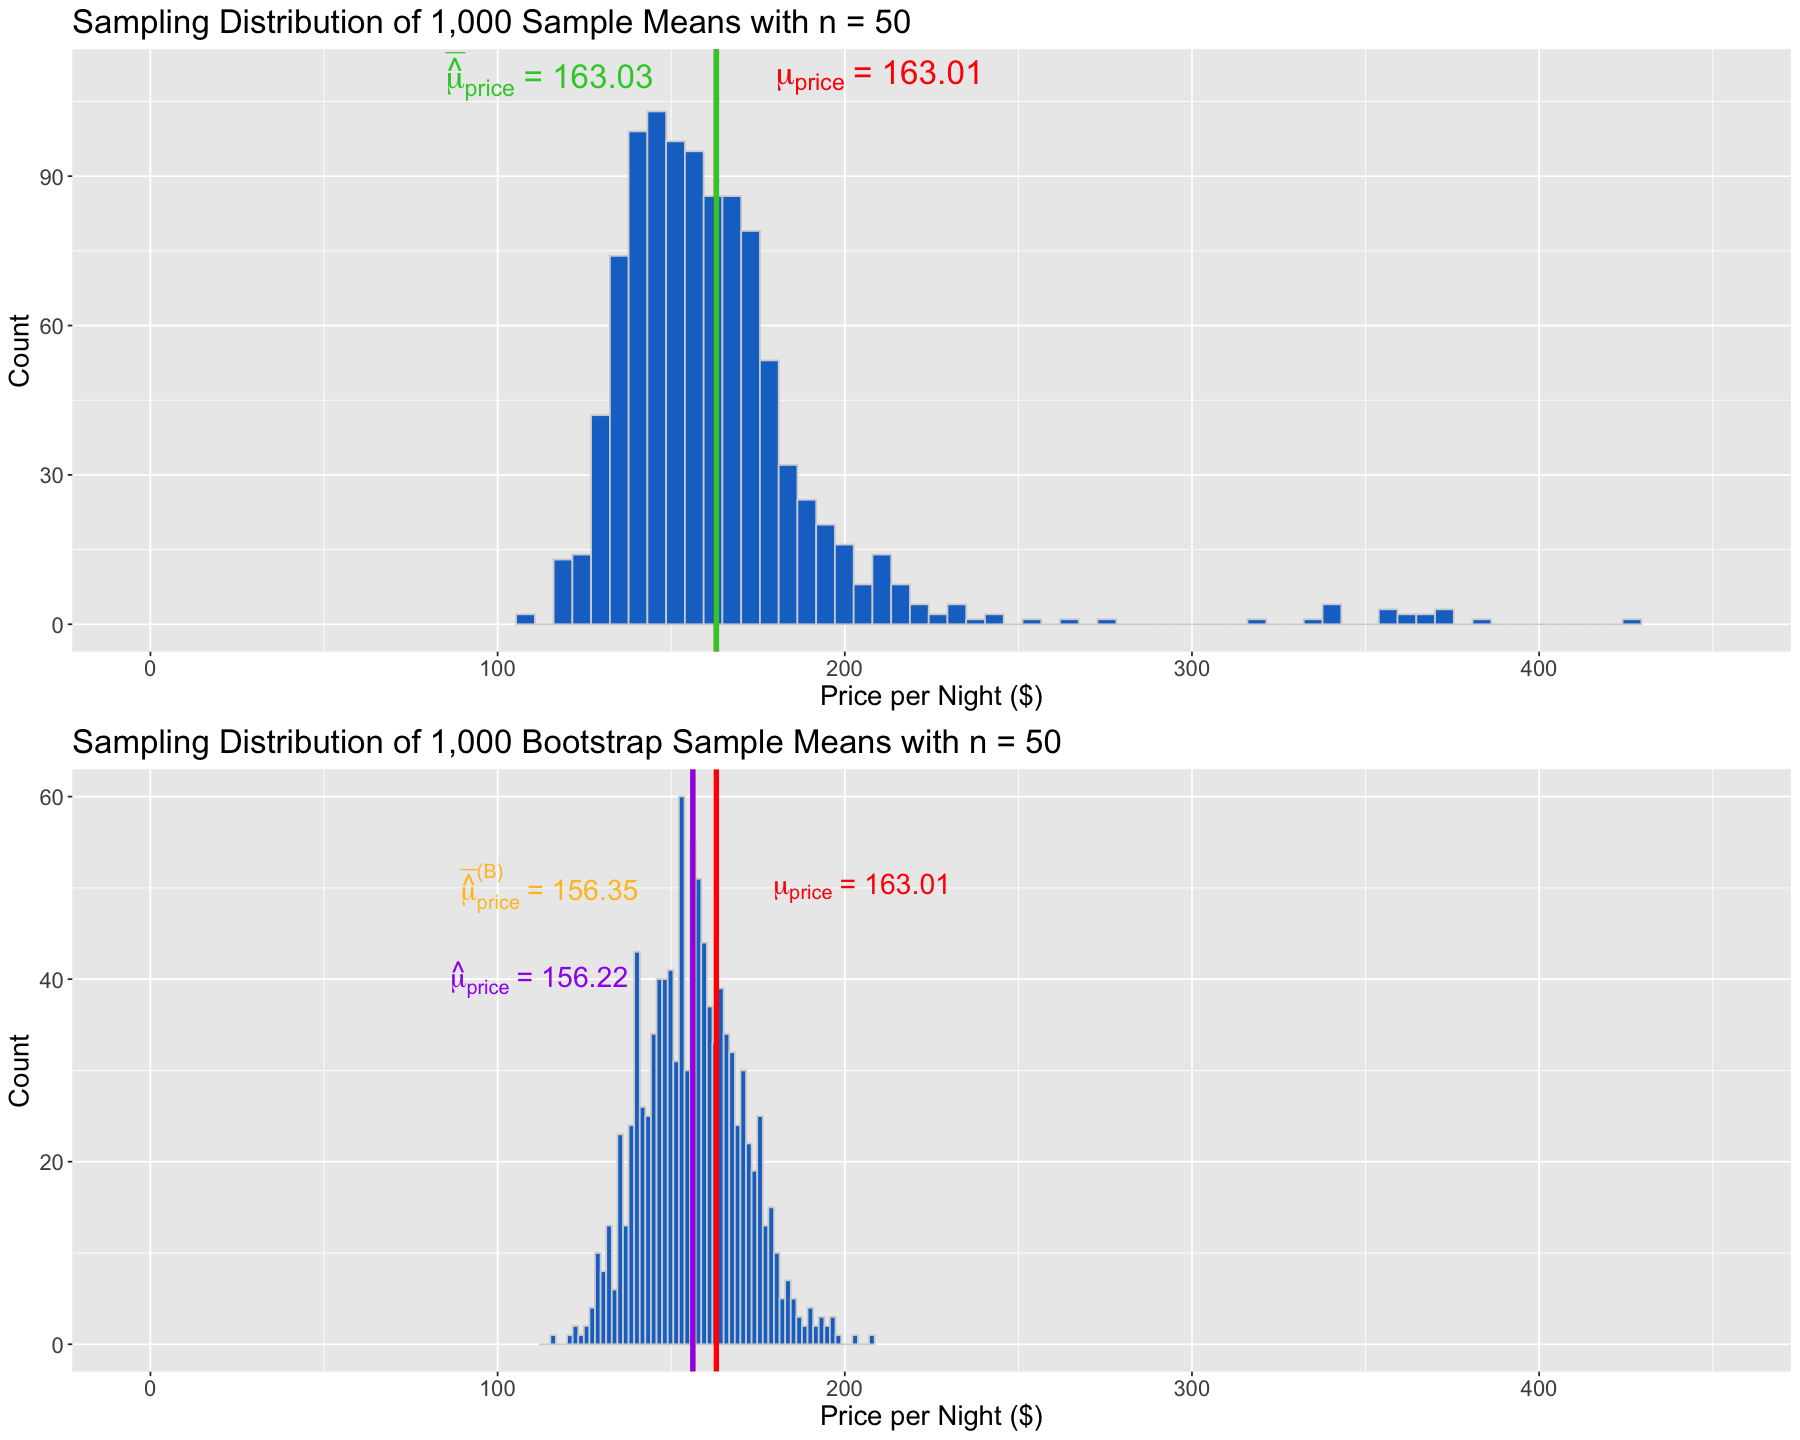

In [41]:
options(repr.plot.width = 15, repr.plot.height = 12)
suppressWarnings(print(plot_grid(sampling_dist_price_n50 + coord_cartesian(xlim = c(0,450)), boot_sampling_dist_price_n50, nrow = 2)))

**What do we notice here?**

- There is a bell shape in both sampling distributions. Moreover, we could state that the spread is graphically similar, except for some outliers on the right-hand side for the regular sampling distribution. This makes the distribution slightly right-skewed.
- The means of these two distributions are different: the mean of the bootstrap sample means is almost exactly that of the original `one_sample` mean, whereas the mean of the sampling distribution of sample means is almost exactly that of the population parameter.

**Here is an idea...**

We can use the distribution of the bootstrap sample means to approximate the sampling distribution of sample means when we only have one sample - and then we can use this to generate a plausible range where we believe the value of true population parameter lies to report along with our estimate!

## 4. What Did We Learn Today? 

- The differences and relationships between the: 
    - Population distribution.
    - Sample distribution.
    - Sampling distribution of the sample estimates.   
- The relationship between sample size and spread of the sampling distribution of the sample estimates.
- How to create a distribution of the bootstrap sample estimates and how it can (and cannot) be used as a proxy for the sampling distribution of the sample estimates.

## 5. Questions we will try to answer next:

- How can we turn this distribution of bootstrap point estimates into a plausible range of values around our observed point estimate (i.e., confidence intervals)?
- How do we interpret these plausible ranges/confidence intervals?

## 6. Acknowledgements

- [Data Science in a box](https://github.com/rstudio-education/datascience-box) by Mine Cetinkaya-Rundel
- [Inference in 3 hours](https://github.com/AllenDowney/CompStats) by Allan Downey
- [Modern Dive: An Introduction to Statistical and Data Sciences via R](https://moderndive.com/index.html) by Chester Ismay and Albert Y. Kim